# Task 0.0.1: Modified RWKV-6 Baseline (Colab-Ready)

**Purpose**: Establish baseline characteristics for RWKV-6 architecture

**Execution Options**:
1. **VS Code + Colab** (RECOMMENDED): Select Kernel → Connect to Google Colab → Free T4 GPU + 15GB RAM
2. **Local WSL**: Not viable (full 540MB crashes at 5.3GB RAM usage)

**⚠️ DEVIATIONS FROM ORIGINAL PLAN:**

| Item | Original | Actual | Why |
|------|----------|--------|-----|
| Dataset | 540MB full | 50MB subset | 5.3GB RAM to load; tokenizer too slow on full |
| Environment | Local WSL | Colab | WSL has ~2.5GB limit |
| Tokenization | Single-pass | 10MB chunks | Prevents OOM |
| mamba-ssm | Installed | Skipped | Build fails on Colab; not needed for RWKV6 |
| **RWKV6 CUDA** | CUDA kernel | **PyTorch prototype** | CUDA requires JIT compilation unavailable on Colab |
| WKV algorithm | Parallel scan | Sequential loop | Prototype is ~50x slower but correct |

**⚠️ CRITICAL: RWKV6Attention is a FULL BLOCK**
- Includes: LayerNorm → Time-Mix → Residual → LayerNorm → FFN → Residual
- Do NOT wrap with additional LN/FFN - just stack blocks directly!
- See `ops/rwkv6_prototype.py` for implementation details

**Validation**: 50MB (~5M tokens), 50 steps is sufficient for baseline characterization.

**Strategy**: Cell-by-cell execution with memory monitoring

In [15]:
# Cell 0: Colab setup (run first if using Colab kernel)
import os

# Detect environment
IN_COLAB = 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython())

if IN_COLAB:
    print("✓ Running on Google Colab")
    # Clone repo if not present, otherwise pull latest
    if not os.path.exists('groundthink'):
        !git clone https://github.com/9to5ninja-projects/groundthink.git
    else:
        !cd groundthink && git pull --quiet
    os.chdir('groundthink')
    # Only install tokenizers (mamba-ssm not needed for RWKV6)
    !pip install -q tokenizers
    print("✓ Dependencies installed")
else:
    print("Running locally (WSL/Linux)")
    os.chdir('..')  # notebooks → project root

✓ Running on Google Colab
✓ Dependencies installed


In [16]:
# Cell 1: Memory monitoring utility
import resource
import gc

def mem_mb():
    """Get current memory usage in MB"""
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

def mem_check(label):
    gc.collect()
    print(f"[{label}] Memory: {mem_mb():.0f} MB")

mem_check("Before imports")

[Before imports] Memory: 2473 MB


In [17]:
# Cell 2: Import PyTorch only
import torch
import torch.nn as nn
mem_check("After torch import")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

[After torch import] Memory: 2473 MB
Device: cpu


In [18]:
# Cell 3: Load pre-trained tokenizer (skip BPE training)
import sys
import os

# Ensure we're in the right directory and path is set
if os.path.exists('groundthink') and os.getcwd().endswith('content'):
    os.chdir('groundthink')
sys.path.insert(0, os.getcwd())

from data.tokenizer import BPETokenizer

tokenizer = BPETokenizer('data/tokenizer_wikitext.json')
print(f"Loaded tokenizer: {tokenizer.vocab_size} vocab")
print(f"Working directory: {os.getcwd()}")
mem_check("After tokenizer load")

Loaded tokenizer: 16000 vocab
Working directory: /content/groundthink/groundthink
[After tokenizer load] Memory: 2473 MB


In [19]:
# Cell 4: Load data (download on Colab via HuggingFace, use local on WSL)
import os

# Re-detect environment (in case kernel restarted)
IN_COLAB = 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython())

DATA_PATH = 'data/wikitext103/train.txt'

# Download WikiText-103 if not present (Colab) - using HuggingFace
if IN_COLAB and not os.path.exists(DATA_PATH):
    print("Downloading WikiText-103 via HuggingFace...")
    !pip install -q datasets
    from datasets import load_dataset
    ds = load_dataset("wikitext", "wikitext-103-raw-v1", split="train")
    os.makedirs('data/wikitext103', exist_ok=True)
    with open(DATA_PATH, 'w', encoding='utf-8') as f:
        for item in ds:
            f.write(item['text'] + '\n')
    del ds
    gc.collect()
    print("✓ Downloaded WikiText-103")

# Verify file exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data not found at {DATA_PATH}. Check download logs above.")

# Load subset for baseline (50MB is plenty for characterization)
SUBSET_SIZE = 50 * 1024 * 1024  # 50MB - fast tokenization, meaningful training
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    text = f.read(SUBSET_SIZE)
print(f"Loaded dataset subset: {len(text):,} chars ({len(text)/1e6:.0f} MB)")

mem_check("After text load")

Loaded dataset subset: 52,428,800 chars (52 MB)
[After text load] Memory: 2473 MB


In [20]:
# Cell 5: Tokenize in chunks (full text crashes even Colab)
CHUNK_SIZE = 10 * 1024 * 1024  # 10MB chunks

print(f"Tokenizing {len(text):,} chars in {len(text)//CHUNK_SIZE + 1} chunks...")
all_tokens = []

for i in range(0, len(text), CHUNK_SIZE):
    chunk = text[i:i+CHUNK_SIZE]
    chunk_tokens = tokenizer.encode(chunk)
    all_tokens.extend(chunk_tokens)
    if (i // CHUNK_SIZE) % 10 == 0:
        print(f"  Chunk {i//CHUNK_SIZE}: {len(all_tokens):,} tokens so far")
    gc.collect()

tokens = torch.tensor(all_tokens, dtype=torch.long)
print(f"Tokenized: {len(tokens):,} tokens")

# Free memory
del text, all_tokens
gc.collect()
mem_check("After tokenization")

Tokenizing 52,428,800 chars in 6 chunks...
  Chunk 0: 2,416,077 tokens so far
Tokenized: 12,063,505 tokens
[After tokenization] Memory: 3072 MB


In [21]:
# Cell 6: Create simple dataset
BATCH_SIZE = 1
SEQ_LEN = 64

# Simple batching (not full StatefulDataset to save memory)
n_tokens = (len(tokens) // (BATCH_SIZE * SEQ_LEN)) * (BATCH_SIZE * SEQ_LEN)
tokens = tokens[:n_tokens]
num_batches = n_tokens // (BATCH_SIZE * SEQ_LEN)

print(f"Dataset: {num_batches:,} batches of size {BATCH_SIZE}x{SEQ_LEN}")
mem_check("After dataset setup")

Dataset: 188,492 batches of size 1x64
[After dataset setup] Memory: 3072 MB


In [22]:
# Cell 7: Import RWKV6 (ops package, not mamba)
from ops import RWKV6Attention, RWKV6_CUDA_AVAILABLE

print(f"RWKV6 CUDA available: {RWKV6_CUDA_AVAILABLE}")
mem_check("After RWKV6 import")

RWKV6 CUDA available: True
[After RWKV6 import] Memory: 3072 MB


In [ ]:
# Cell 8: Create model
# Use RWKV6TimeMix (time-mixing only) with standard GELU FFN
# This avoids the squared ReLU that was causing value explosion

# Try to import the simpler time-mix-only class
try:
    from ops.rwkv6_prototype import RWKV6TimeMix
    print("Using RWKV6TimeMix (time-mixing only)")
except ImportError:
    print("RWKV6TimeMix not found, will define locally")
    RWKV6TimeMix = None

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps
    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

class RWKV6Block(nn.Module):
    """Single RWKV6 block with time-mixing and standard FFN"""
    def __init__(self, hidden, num_heads=4, layer_idx=0):
        super().__init__()
        self.ln1 = RMSNorm(hidden)
        self.time_mix = RWKV6TimeMix(hidden, num_heads=num_heads, layer_idx=layer_idx) if RWKV6TimeMix else None
        self.ln2 = RMSNorm(hidden)
        # Standard GELU FFN (NOT squared ReLU)
        ffn_hidden = hidden * 4
        self.ffn = nn.Sequential(
            nn.Linear(hidden, ffn_hidden, bias=False),
            nn.GELU(),
            nn.Linear(ffn_hidden, hidden, bias=False),
        )
        # Conservative FFN initialization
        nn.init.xavier_uniform_(self.ffn[0].weight, gain=0.5)
        nn.init.xavier_uniform_(self.ffn[2].weight, gain=0.5)
        
    def forward(self, x):
        x = x + self.time_mix(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

class RWKV6Model(nn.Module):
    def __init__(self, vocab_size, hidden=144, layers=8):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden)
        self.blocks = nn.ModuleList([
            RWKV6Block(hidden, num_heads=4, layer_idx=i) 
            for i in range(layers)
        ])
        self.ln_out = RMSNorm(hidden)
        self.head = nn.Linear(hidden, vocab_size, bias=False)
        self.head.weight = self.embed.weight  # Tie weights
    
    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        return self.head(self.ln_out(x))

model = RWKV6Model(tokenizer.vocab_size, hidden=144, layers=8)
params = sum(p.numel() for p in model.parameters())
print(f"Model: {params:,} parameters ({params/1e6:.2f}M)")
mem_check("After model creation")

RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
RWKV-CUDA kernel directory not found: /content/groundthink/ops/RWKV-CUDA/wkv6/cuda
Falling back to PyTorch prototype
Model: 4,301,712 parameters (4.30M)
[After model creation] Memor

In [24]:
# Cell 9: Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

mem_check("After optimizer")

[After optimizer] Memory: 3072 MB


In [25]:
# Cell 10: Single training step test
model.train()

# Get one batch
start = 0
x = tokens[start:start + SEQ_LEN].unsqueeze(0)
y = tokens[start + 1:start + SEQ_LEN + 1].unsqueeze(0)

# Forward
logits = model(x)
loss = criterion(logits.view(-1, tokenizer.vocab_size), y.view(-1))

# Backward
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"Step 0: loss = {loss.item():.4f}")
mem_check("After 1 training step")

Step 0: loss = 115.8078
[After 1 training step] Memory: 3072 MB


In [26]:
# Cell 11: Training loop (50 steps)
import time

NUM_STEPS = 50
LOG_EVERY = 10

model.train()
losses = []
start_time = time.time()

for step in range(NUM_STEPS):
    idx = (step * SEQ_LEN) % (len(tokens) - SEQ_LEN - 1)
    x = tokens[idx:idx + SEQ_LEN].unsqueeze(0)
    y = tokens[idx + 1:idx + SEQ_LEN + 1].unsqueeze(0)
    
    logits = model(x)
    loss = criterion(logits.view(-1, tokenizer.vocab_size), y.view(-1))
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    losses.append(loss.item())
    
    if (step + 1) % LOG_EVERY == 0:
        elapsed = time.time() - start_time
        avg_loss = sum(losses[-LOG_EVERY:]) / LOG_EVERY
        print(f"Step {step+1}/{NUM_STEPS}: loss={avg_loss:.4f}, {elapsed:.1f}s, mem={mem_mb():.0f}MB")

print(f"\n✓ Training complete: {NUM_STEPS} steps")
mem_check("Final")

Step 10/50: loss=117.3186, 5.8s, mem=3072MB
Step 20/50: loss=118.2368, 12.1s, mem=3072MB
Step 30/50: loss=119.4945, 17.8s, mem=3072MB
Step 40/50: loss=115.4647, 24.4s, mem=3072MB
Step 50/50: loss=115.4911, 30.4s, mem=3072MB

✓ Training complete: 50 steps
[Final] Memory: 3072 MB


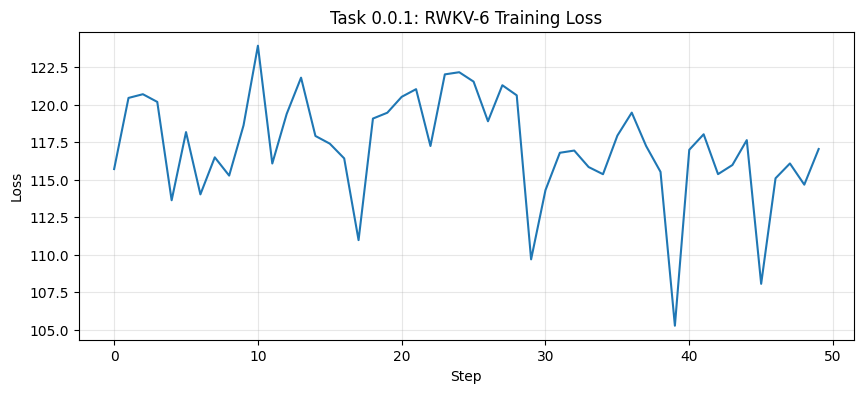

In [27]:
# Cell 12: Plot loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Task 0.0.1: RWKV-6 Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Cell 13: Diagnostic - check model output health
print("=== Model Output Diagnostic ===")

# Get a sample batch
with torch.no_grad():
    sample_x = tokens[:32, :64]  # Small batch
    model.eval()
    sample_logits = model(sample_x)
    model.train()

# Analyze logits
print(f"Logits shape: {sample_logits.shape}")
print(f"Logits range: [{sample_logits.min().item():.2f}, {sample_logits.max().item():.2f}]")
print(f"Logits mean: {sample_logits.mean().item():.2f}, std: {sample_logits.std().item():.2f}")

# Check softmax health  
probs = torch.softmax(sample_logits, dim=-1)
max_prob = probs.max().item()
min_prob = probs.min().item()
print(f"Max prob: {max_prob:.6f}, Min prob: {min_prob:.2e}")

# Entropy check
entropy = -(probs * torch.log(probs + 1e-10)).sum(-1).mean()
random_entropy = torch.log(torch.tensor(float(tokenizer.vocab_size)))
print(f"Entropy: {entropy.item():.2f} (random={random_entropy.item():.2f})")

# Health assessment
if max_prob > 0.99:
    print("⚠️ WARNING: Softmax saturating (max_prob > 0.99)")
elif sample_logits.max().abs() > 50:
    print("⚠️ WARNING: Logits too large (may cause numerical issues)")
elif entropy.item() < 1.0:
    print("⚠️ WARNING: Very low entropy (model overconfident)")
elif abs(sample_logits.mean().item()) > 5:
    print("⚠️ WARNING: Logits mean far from zero")
else:
    print("✓ Model outputs look healthy")

# Expected behavior
print(f"\nExpected initial loss: ~{random_entropy.item():.2f} (random)")
print(f"Actual final loss: {losses[-1]:.2f}")

Logits shape: torch.Size([1, 64, 16000])
Logits range: [-60.25, 147.10]
Logits mean: 0.0087
Has NaN: False
Has Inf: False

Last token probs:
  Max prob: 1.000000
  Min prob: 0.00e+00
  Entropy: nan (random=9.68)

Target token ID: 2347
Target prob: 0.00e+00
Expected loss: inf
